# Используемые библиотеки и функции

In [100]:
import pandas as pd
import numpy as np
from random import random
from urllib.parse import urlparse, parse_qs
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest


def logging_decorator(func):
    def wrapper(*args, **kwargs):
        print(f'{func.__name__} started in: {datetime.now()}')
        result = func(*args, **kwargs)
        print(f'{func.__name__} complited in: {datetime.now()}')
        return result
    return wrapper


def get_params(row: str, param: str) -> str:
    try:
        return parse_qs(urlparse(row).query)[param][0]
    except Exception:
        return None

    
def referer_by_prob(df1: pd.DataFrame, fields: list|tuple) -> str:
    rand = random()
    return df1[(df1[fields[0]] <= rand) & (df1[fields[1]] > rand)]['http_referer'].iloc[0]

       
def a_b_split(uuid: str) -> bool:
    return int(uuid[-1]) % 2 == 0


def type_to_data(df: pd.DataFrame, data: dict) -> None:
    for сol, item in data.items():
        if item == 'date':
            df[сol] = pd.to_datetime(df[сol], format="%Y-%m-%d")
        else:
            df[сol] = pd.to_datetime(df[сol])

    
@logging_decorator
def create_multi_df(name: str, data: str, quontity: int, path='~/') -> pd.DataFrame:
    dfs = dict()
    for i in range(quontity):
        try:
            if data == 'csv':
                dfs[i] = pd.read_csv(f"""{path}{name}{i}.{data}""", sep =';')
            else:
                dfs[i] = pd.read_excel(f"""{path}{name}{i}.{data}""")
        except FileNotFoundError as file_error:
            print(file_error)
    return pd.concat(dfs, axis=0, ignore_index=True)
            

@logging_decorator
def probability_df(df: pd.DataFrame, grouped: str, param: str) -> pd.DataFrame:
    df_final = df.groupby(grouped).agg({param:'nunique'}).sort_values(by=param, ascending=False)
    df_final[param] = df_final[param].apply(lambda x: x / df_final[param].sum())
    df_final = df_final.sort_values(by='uuid')
    df_final = df_final.cumsum()
    df_final['prev_data'] = df_final.shift(1).fillna(0)
    return df_final.reset_index()

@logging_decorator
def parse_params_df(df: pd.DataFrame, field: str):
    df['home'] = df[field].apply(lambda x: urlparse(x)[1])
    df['path'] = df[field].apply(lambda x: urlparse(x)[2])
    df['utm_medium'] = df[field].apply(lambda x: get_params(x, 'utm_medium'))
    df['utm_source'] = df[field].apply(lambda x: get_params(x, 'utm_source'))
    df['utm_campaign'] = df[field].apply(lambda x: get_params(x, 'utm_campaign'))
    df['utm_content'] = df[field].apply(lambda x: get_params(x, 'utm_content'))
    df['utm_term'] = df[field].apply(lambda x: get_params(x, 'utm_term'))

# Подготовительный этап работы с данными

In [2]:
# импорт данных в пандас и изменение данных в формат даты
df = create_multi_df('access_log_202406061144_', data='csv', quontity=5)
type_to_data(df, {'dt': 'date', 'tme': 'datetime'})

# разбиваем данные на 2 группы
df['a_b'] = df.uuid.apply(a_b_split)

# оставляемые только нужные по заданию логи
df_ab = df[((df.uri == '/')) | ((df.host == 'auto.drom.ru') & (df.uri == '/addbull/'))]

# убираем дубли по логам
df_ab.drop_duplicates(subset=['uuid','uri'], inplace=True)

create_multi_df started in: 2024-07-13 19:27:43.421350
[Errno 2] No such file or directory: '/Users/aleksandrnevmerzickij/access_log_202406061144_0.csv'
create_multi_df complited in: 2024-07-13 19:27:46.145466


In [3]:
# получаем значения для заполнения пропущенных значений
p_df = probability_df(df_ab, 'http_referer', 'uuid')
df_na = df_ab[df_ab.http_referer.isna()].drop_duplicates(subset='uuid')
prod  = [referer_by_prob(p_df, ('prev_data', 'uuid')) for _ in range(len(df_na))]
df_na['http_referer'] = prod

# заполняем пропущенные значения http_referer
df_merged = df_ab.merge(df_na[['uuid','http_referer']], how='left', on='uuid')
df_merged['http_referer'] = df_merged['http_referer_y'].fillna(df_merged['http_referer_x'])
df_merged.drop(columns=['http_referer_x', 'http_referer_y'], inplace=True)
parse_params_df(df_merged, field='http_referer')

# удаляем дубли и сводим данные с откликом и таргетом а/б теста в единую таблицу
target = df_merged.iloc[:, 4:].drop_duplicates(subset=['uuid'])
response = df_merged[df_merged.uri != '/'].iloc[:, 4:].drop_duplicates(subset=['uuid'])
target['Target'] = 1
target['Response'] = 0
target.loc[target.uuid.isin(response.uuid), 'Response'] = 1

# итоговый датафрейм после преобразований
target

probability_df started in: 2024-07-13 19:27:57.840262
probability_df complited in: 2024-07-13 19:28:02.156421
parse_params_df started in: 2024-07-13 19:28:38.636638
parse_params_df complited in: 2024-07-13 19:28:48.255264


,uuid,a_b,http_referer,home,path,utm_medium,utm_source,utm_campaign,utm_content,utm_term,Target,Response
0,CE70AF0C124FD4BAED5381A2F93208FA1,False,https://baza.drom.ru/personal/actual/bulletins,baza.drom.ru,/personal/actual/bulletins,None,None,None,None,None,1,0
1,DDEB19C34157DED43439E332BDD56C955,False,https://baza.drom.ru/,baza.drom.ru,/,None,None,None,None,None,1,0
2,EB05C9FA3E837AFE61F72209050858D22,True,https://auto.drom.ru/dealer140137/page2/,auto.drom.ru,/dealer140137/page2/,None,None,None,None,None,1,0
3,E2BC6E3507BB3B229E19BA8B37D984013,False,https://baza.drom.ru/tomsk/wheel/tire/?section...,baza.drom.ru,/tomsk/wheel/tire/,None,None,None,None,None,1,0
4,8ED96DB51304451E5DC547FA332C0B551,False,https://yandex.ru/,yandex.ru,/,None,None,None,None,None,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
369382,E2D1F8F2F4B2508B6524321298020D8D7,False,https://www.drom.ru/pdd/onlineschool/,www.drom.ru,/pdd/onlineschool/,None,None,None,None,None,1,1
369383,FC16C570E7F395F67F78F11893D2B5527,False,https://barnaul.drom.ru/honda/,barnaul.drom.ru,/honda/,None,None,None,None,None,1,0
369384,7C3CA994F7B473BEC691C1C1B53E89E03,False,https://www.drom.ru/catalog/honda/prelude/spec...,www.drom.ru,/catalog/honda/prelude/specs/engine_capacity/,None,None,None,None,None,1,0
369385,1F00E4CFCFF7C856C9E6F6541141B66C4,True,https://www.google.com/,www.google.com,/,None,None,None,None,None,1,0


# A/B Тест

In [58]:
#генерируем переменные на основе данных датасета
alpha = 0.05
# группа A видели по старому сайт, а B - по-новому 
group_a = np.array([target[target.a_b == 1].sample(frac=alpha).Response.mean() for i in range(1000)])
group_b = np.array([target[target.a_b == 0].sample(frac=alpha).Response.mean() for i in range(1000)])

Определяем тип распределения с помощью графиков:

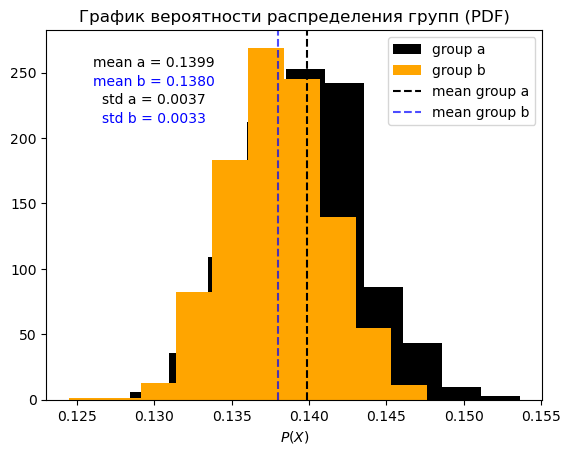

In [125]:
plt.hist(group_a, label='group a', color='black')
plt.hist(group_b, label='group b', color='orange')
# статистики распределения
b_mean = group_b.mean()
a_mean = group_a.mean()
b_std = group_b.std(ddof=1)
a_std = group_a.std(ddof=1)
# вывод данных на график
plt.axvline(a_mean, linestyle='--', color='black', label='mean group a', alpha=1)
plt.axvline(b_mean, linestyle='--', color='blue', label='mean group b', alpha=0.7)
plt.xlabel('$P(X)$')
plt.text(0.13, plt.ylim()[1]*0.9, f'mean a = {a_mean:.4f}', color='black', ha='center')
plt.text(0.13, plt.ylim()[1]*0.85, f'mean b = {b_mean:.4f}', color='blue', ha='center')
plt.text(0.13, plt.ylim()[1]*0.8, f'std a = {a_std:.4f}', color='black', ha='center')
plt.text(0.13, plt.ylim()[1]*0.75, f'std b = {b_std:.4f}', color='blue', ha='center')
plt.legend()
plt.title('График вероятности распределения групп (PDF)')
plt.show()

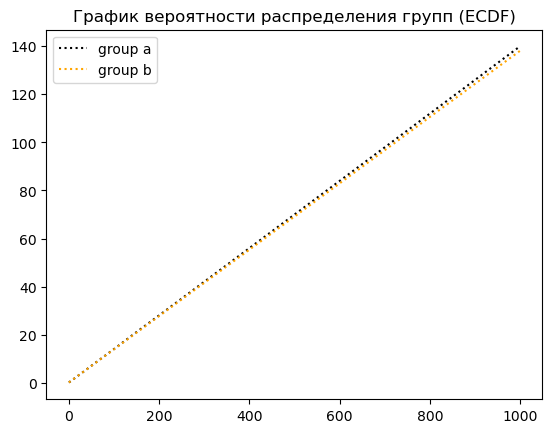

In [62]:
plt.plot(np.cumsum(group_a), label='group a', color='black', linestyle=':')
plt.plot(np.cumsum(group_b), label='group b', color='orange', linestyle=':')
plt.title('График вероятности распределения групп (ECDF)')
plt.legend()
plt.show()

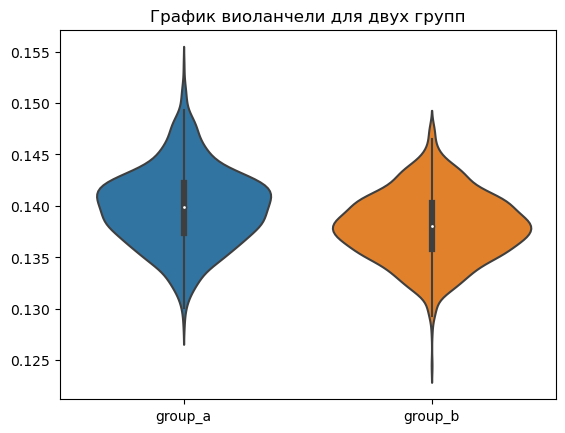

In [78]:
sns.violinplot([group_a, group_b])
plt.xticks([0, 1], ['group_a', 'group_b'])
plt.title('График виоланчели для двух групп')
plt.show()

Вывод:
исходя из графиков видим, что группы схожи, но группа А имеет большее STD, но и большее E(X)

In [98]:
# формируем статистики для тестирования проп тестом
a_resp = len(target[(target.a_b == 1) & (target.Response == 1)])
b_resp = len(target[(target.a_b == 0) & (target.Response == 1)])
a_target = len(target[(target.a_b == 1) & (target.Target == 1)])
b_target = len(target[(target.a_b == 0) & (target.Target == 1)])

In [121]:
z_stat, p_value = proportions_ztest((a_resp, b_resp),
                                    (a_target, b_target),
                                    alternative='two-sided')

Результат тестирования выше, чем уровень ошибки I рода (alpha), поэтому нулевая гипотеза о равности двух выборок подтверждается:

In [124]:
p_value > alpha

True